In [1]:
import warnings
import pandas as pd

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [3]:
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import os
import time
import random
import itertools
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import catboost as cb

import phik
from phik.report import plot_correlation_matrix
from phik import report
# import eli5
# from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from tqdm.notebook import tqdm

from src.PM_eq import penman_monteith
from src.process_fluxes import create_rolling_windows

ModuleNotFoundError: No module named 'catboost'

# Data Preprocessing

In [26]:
mod = np.load('../data_v02/MOD_features_all.npy', allow_pickle=True)
mod_idxs = set(np.load('../data_v02/MOD_target_idx_all.npy', allow_pickle=True))
era5 = np.load('../data_v02/ERA5_features.npy', allow_pickle=True)
era5_idxs = era5[:,0,-1].astype(int)
era5 = era5[:,:,:-1] # drop last (idx)

fluxes = pd.read_csv('../data_v02/target_fluxes_MidWest_LE.csv')
fluxes = fluxes[fluxes['LE_F_MDS_QC']>=0.75]
keep_idxs = [idx for idx in fluxes.index.tolist() if (idx in era5_idxs) and (idx in mod_idxs)]
fluxes = fluxes.loc[keep_idxs,:]
fluxes['TIMESTAMP'] = pd.to_datetime(fluxes.TIMESTAMP, format='%Y%m%d')
targets = fluxes.LE_F_MDS.values

fluxes

,TIMESTAMP,LE_F_MDS,LE_F_MDS_QC,NETRAD,G_F_MDS,TA_F,VPD_F,WS_F,PA_F,site,H_F_MDS,lat,lon,IGBP
0,2003-05-24,19.2224,1.0000,236.108854,-1.567770,11.213,10.345,1.841,98.421,FLX_US-Wi1,138.470000,46.7305,-91.2329,DBF
1,2003-05-25,24.2024,1.0000,227.120214,-1.126670,12.308,10.551,1.835,98.471,FLX_US-Wi1,112.405000,46.7305,-91.2329,DBF
2,2003-05-26,19.4017,0.9375,249.112486,0.019932,14.778,12.203,1.660,98.656,FLX_US-Wi1,108.937000,46.7305,-91.2329,DBF
3,2003-05-27,23.7468,1.0000,244.104535,1.914990,18.154,15.802,1.532,98.265,FLX_US-Wi1,112.939000,46.7305,-91.2329,DBF
4,2003-05-28,42.2603,0.9375,246.821474,0.114018,14.890,6.921,2.285,97.722,FLX_US-Wi1,85.043500,46.7305,-91.2329,DBF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155271,2003-09-11,55.7628,1.0000,126.808894,7.353920,23.534,10.864,2.743,96.827,AMF_US-Wi3,15.796000,46.6347,-91.0987,DBF
155272,2003-09-13,31.6040,1.0000,65.703064,-8.120460,15.390,2.544,1.353,96.572,AMF_US-Wi3,-8.821360,46.6347,-91.0987,DBF
155273,2003-09-14,54.2463,1.0000,92.268000,-8.471200,13.966,4.375,1.341,96.912,AMF_US-Wi3,-10.596500,46.6347,-91.0987,DBF
155274,2003-09-15,44.2428,1.0000,99.622415,-3.575530,12.401,3.585,1.304,96.968,AMF_US-Wi3,-0.490375,46.6347,-91.0987,DBF


In [27]:
era5_idxs = pd.Series(list(era5_idxs))
era5_idxs.index = np.arange(len(era5_idxs))
valid_feature_indices = era5_idxs[era5_idxs.isin(fluxes.index)].index.values
era5_features = era5[valid_feature_indices]

mod_idxs = pd.Series(list(mod_idxs))
mod_idxs.index = np.arange(len(mod_idxs))
valid_feature_indices = mod_idxs[mod_idxs.isin(fluxes.index)].index.values
mod_features = mod[valid_feature_indices]
mod_features = mod_features[:,:,:-1]#Dropping Coarse_Resolution_Internal_CM

NDVI = (mod_features[:,:,1] - mod_features[:,:,0])/(mod_features[:,:,1] + mod_features[:,:,0])
EVI = (mod_features[:,:,1] - mod_features[:,:,0])/(mod_features[:,:,1] + 6*mod_features[:,:,0] - 7.5*mod_features[:,:,2] + 1)
GNDVI = (mod_features[:,:,1] - mod_features[:,:,3])/(mod_features[:,:,1] + mod_features[:,:,3])
SAVI = (mod_features[:,:,1] - mod_features[:,:,0])/(mod_features[:,:,1] + mod_features[:,:,0] + 0.5)*1.5
ARVI = (mod_features[:,:,1] + mod_features[:,:,2] - 2*mod_features[:,:,0])/(mod_features[:,:,1] + mod_features[:,:,2] + 2*mod_features[:,:,0])

#pm_flux = penman_monteith(fluxes, fluxes.index, fluxes, mode='ground').values / 10
pm_era = penman_monteith(era5_features, fluxes.index, fluxes, mode='era5') / 10

features = np.concatenate([era5_features, mod_features, pm_era[:, :, np.newaxis],
                           NDVI[:,:, np.newaxis], EVI[:,:, np.newaxis], GNDVI[:,:, np.newaxis],
                           SAVI[:,:, np.newaxis], ARVI[:,:, np.newaxis]], axis=2)

era_names = list(np.loadtxt('../data_v02/ERA5_features_names.txt', dtype=str))[:-1]
mod_names = [
          'SensorZenith', 'SensorAzimuth', 'SolarZenith', 'SolarAzimuth',
         'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04',
         'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07', 
]

In [8]:
era_names

[np.str_('temperature_2m'),
 np.str_('dewpoint_temperature_2m'),
 np.str_('u_component_of_wind_10m'),
 np.str_('v_component_of_wind_10m'),
 np.str_('surface_net_solar_radiation_sum'),
 np.str_('total_evaporation_sum'),
 np.str_('surface_pressure'),
 np.str_('total_precipitation_sum')]

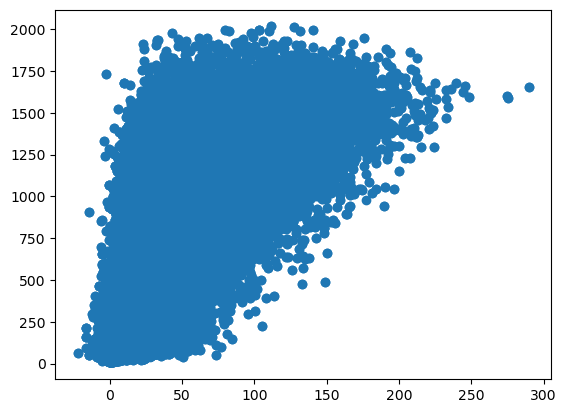

In [19]:
plt.scatter(fluxes.LE_F_MDS.values, pm_era[:,-1]*10)

array([19.2224, 24.2024, 19.4017, ..., 54.2463, 44.2428, 51.6369],
      shape=(100031,))

In [28]:
df = pd.DataFrame(data=features[:,-1,:], columns=era_names + mod_names + ['LE_PM'] + ['NDVI', 'EVI', "GNDVI", 'SAVI', 'ARVI']) 

In [29]:
cols = [x for x in df.columns if not x.endswith('_ewm')]
for idx, col in enumerate(cols):
    if col in ['surface_net_solar_radiation_sum','total_evaporation_sum','total_precipitation_sum',]:
        ewm = pd.DataFrame(features[:,:,idx]).T.rolling(window=30).sum().iloc[[-1]].values
        df[col+'_rol_30'] = ewm.T
        ewm_7 = pd.DataFrame(features[:,:,idx]).T.rolling(window=7).sum().iloc[[-1]].values
        df[col+'_rol_7'] = ewm_7.T
    else:
      ewm = pd.DataFrame(features[:,:,idx]).T.rolling(window=30, min_periods=1).mean().iloc[[-1]].values#.ewm(span=3, adjust=False).mean()
      df[col+'_rol_30'] = ewm.T
      ewm_7 = pd.DataFrame(features[:,:,idx]).T.rolling(window=7, min_periods=1).mean().iloc[[-1]].values#.ewm(span=3, adjust=False).mean()
      df[col+'_rol_7'] = ewm_7.T
    Min = pd.DataFrame(features[:,:,idx]).T.min(axis=0).values#.ewm(span=3, adjust=False).mean()
    df[col+'_min'] = Min
    Max = pd.DataFrame(features[:,:,idx]).T.max(axis=0).values#.ewm(span=3, adjust=False).mean()
    df[col+'_max'] = Max
    std = pd.DataFrame(features[:,:,idx]).T.std(axis=0).values#.ewm(span=3, adjust=False).mean()
    df[col+'_std'] = std
df

,temperature_2m,dewpoint_temperature_2m,u_component_of_wind_10m,v_component_of_wind_10m,surface_net_solar_radiation_sum,total_evaporation_sum,surface_pressure,total_precipitation_sum,SensorZenith,SensorAzimuth,...,SAVI_rol_30,SAVI_rol_7,SAVI_min,SAVI_max,SAVI_std,ARVI_rol_30,ARVI_rol_7,ARVI_min,ARVI_max,ARVI_std
0,281.343946,274.774182,-2.073795,-1.360031,26897492.0,-0.002752,99228.292806,8.702277e-07,-7688.0,1044.0,...,-2.812059,-3.402160,-10.580120,-0.341583,2.971624,2.932151,5.971087,-44.711864,27.949356,11.366360
1,282.464883,275.920165,-0.567736,-0.957006,25328886.0,-0.002556,99148.981283,4.280953e-06,-6919.0,5713.0,...,-3.080630,-4.136137,-15.717959,-0.341583,3.699831,2.905350,5.918134,-44.711864,27.949356,11.363106
2,284.084068,277.467796,-0.467478,-0.748162,27070394.0,-0.002731,99351.942220,-3.470632e-09,10194.0,989.0,...,-3.094565,-4.169035,-15.717959,-0.341583,3.691789,2.903013,5.913157,-44.711864,27.949356,11.363742
3,285.546112,280.368587,-0.012711,0.381809,26986822.0,-0.002901,99198.711751,1.704693e-06,-7178.0,4828.0,...,-3.205182,-4.447361,-15.717959,-0.341583,3.779275,2.855912,5.816337,-44.711864,27.949356,11.352651
4,287.724267,283.038661,2.504967,-0.589438,22430258.0,-0.002726,98359.807129,2.112186e-03,9959.0,2853.0,...,-3.214104,-4.468402,-15.717959,-0.341583,3.773136,2.853934,5.812325,-44.711864,27.949356,11.353173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100026,297.318900,287.853605,-0.168409,4.767782,14505586.0,-0.001776,97233.082194,9.688994e-05,-7574.0,2845.0,...,-3.881847,-3.305702,-16.478413,-0.407683,4.500915,3.391581,2.035396,-4.139233,21.158958,5.145233
100027,291.268883,287.133067,1.514562,2.380533,10545720.0,-0.001241,96738.132161,6.713572e-06,-7990.0,1027.0,...,-3.372298,-3.377655,-16.269280,-0.407683,3.847659,4.053568,5.828223,-4.139233,23.634561,6.333234
100028,289.352179,282.922236,2.427099,-0.343477,9703412.0,-0.001254,97260.959310,1.046062e-05,-6951.0,5714.0,...,-3.623933,-4.077157,-16.269280,-0.407683,4.360848,4.022291,5.774212,-4.139233,23.634561,6.331761
100029,287.695470,281.925993,3.045816,-0.182213,12917008.0,-0.001712,97294.923014,1.151973e-03,10348.0,1008.0,...,-3.637381,-4.110781,-16.269280,-0.407683,4.352550,4.021106,5.769007,-4.139233,23.634561,6.332555


In [30]:
df['doy'] = fluxes['TIMESTAMP'].reset_index(drop=True).dt.dayofyear
df['lat'] = fluxes.lat.values
df['lon'] = fluxes.lon.values
df['IGBP'] = fluxes.IGBP.values
df['IGBP'] = df['IGBP'].astype('category')
# df['t2m'] = fluxes.TA_F.values
# df['sp'] = fluxes.PA_F.values
# df['netrad'] = fluxes.NETRAD.values
# df['ground_flux'] = fluxes.G_F_MDS.values
# df['sense_heat'] = fluxes.H_F_MDS.values
# df['vpd'] = fluxes.VPD_F.values
# df['wind'] = fluxes.WS_F.values
#df['LE_PM'] = pm_flux
df['LE'] = fluxes.LE_F_MDS.values
df

,temperature_2m,dewpoint_temperature_2m,u_component_of_wind_10m,v_component_of_wind_10m,surface_net_solar_radiation_sum,total_evaporation_sum,surface_pressure,total_precipitation_sum,SensorZenith,SensorAzimuth,...,ARVI_rol_30,ARVI_rol_7,ARVI_min,ARVI_max,ARVI_std,doy,lat,lon,IGBP,LE
0,281.343946,274.774182,-2.073795,-1.360031,26897492.0,-0.002752,99228.292806,8.702277e-07,-7688.0,1044.0,...,2.932151,5.971087,-44.711864,27.949356,11.366360,144,46.7305,-91.2329,DBF,19.2224
1,282.464883,275.920165,-0.567736,-0.957006,25328886.0,-0.002556,99148.981283,4.280953e-06,-6919.0,5713.0,...,2.905350,5.918134,-44.711864,27.949356,11.363106,145,46.7305,-91.2329,DBF,24.2024
2,284.084068,277.467796,-0.467478,-0.748162,27070394.0,-0.002731,99351.942220,-3.470632e-09,10194.0,989.0,...,2.903013,5.913157,-44.711864,27.949356,11.363742,146,46.7305,-91.2329,DBF,19.4017
3,285.546112,280.368587,-0.012711,0.381809,26986822.0,-0.002901,99198.711751,1.704693e-06,-7178.0,4828.0,...,2.855912,5.816337,-44.711864,27.949356,11.352651,147,46.7305,-91.2329,DBF,23.7468
4,287.724267,283.038661,2.504967,-0.589438,22430258.0,-0.002726,98359.807129,2.112186e-03,9959.0,2853.0,...,2.853934,5.812325,-44.711864,27.949356,11.353173,148,46.7305,-91.2329,DBF,42.2603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100026,297.318900,287.853605,-0.168409,4.767782,14505586.0,-0.001776,97233.082194,9.688994e-05,-7574.0,2845.0,...,3.391581,2.035396,-4.139233,21.158958,5.145233,254,46.6347,-91.0987,DBF,55.7628
100027,291.268883,287.133067,1.514562,2.380533,10545720.0,-0.001241,96738.132161,6.713572e-06,-7990.0,1027.0,...,4.053568,5.828223,-4.139233,23.634561,6.333234,256,46.6347,-91.0987,DBF,31.6040
100028,289.352179,282.922236,2.427099,-0.343477,9703412.0,-0.001254,97260.959310,1.046062e-05,-6951.0,5714.0,...,4.022291,5.774212,-4.139233,23.634561,6.331761,257,46.6347,-91.0987,DBF,54.2463
100029,287.695470,281.925993,3.045816,-0.182213,12917008.0,-0.001712,97294.923014,1.151973e-03,10348.0,1008.0,...,4.021106,5.769007,-4.139233,23.634561,6.332555,258,46.6347,-91.0987,DBF,44.2428


In [31]:
colors = ['brown', 'darkcyan']
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

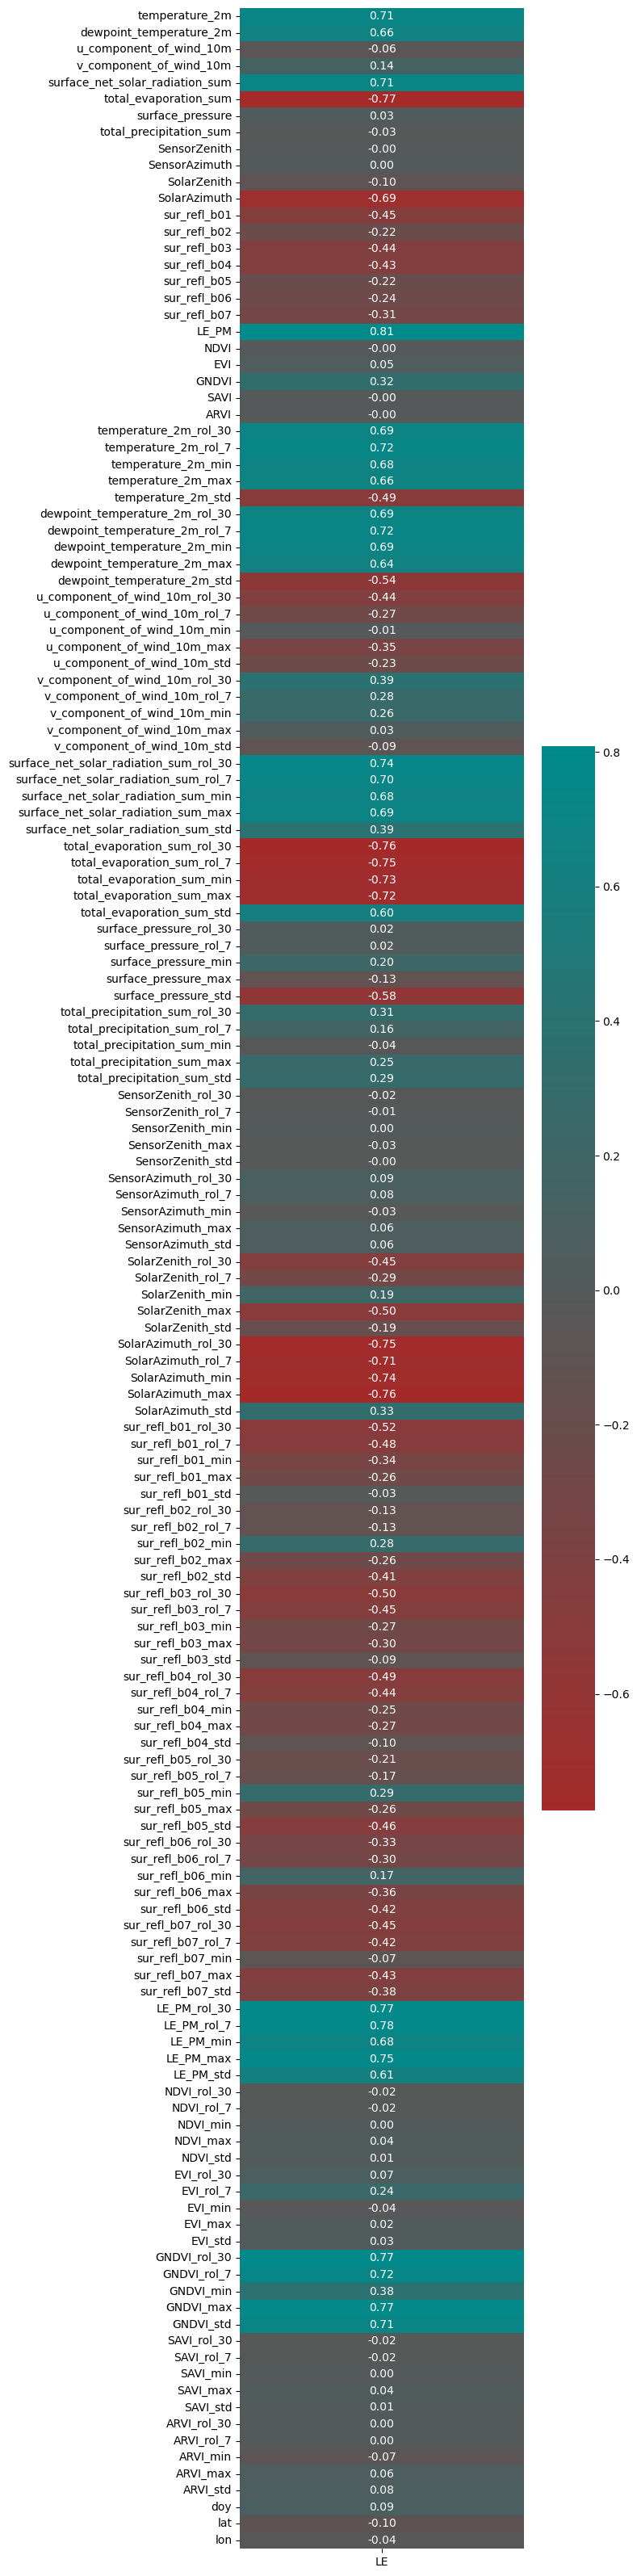

In [32]:
correlation_matrix = df.drop('IGBP', axis=1).corr()[["LE"]].iloc[:-1]

plt.figure(figsize=(8, 32))
sns.heatmap(correlation_matrix, annot=True, cmap=custom_cmap, cbar=True, fmt=".2f")
plt.tight_layout()
#plt.savefig('./fig/targets_heatmap_ground.png')
plt.show()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['LE'], axis=1), df['LE'], stratify=df['IGBP'],
                                                    test_size=0.3, shuffle=True, random_state=31)

# LightGBM

### LOGS:
**Stratified by IGBP:**

R2: 0.987	RMSE: 4.577	MAE: 1.26

In [41]:
train_data = lgb.Dataset(X_train, label=y_train.astype(float), categorical_feature='IGBP')
test_data = lgb.Dataset(X_test, label=y_test.astype(float), reference=train_data, categorical_feature='IGBP')

In [ ]:
# %%timeit -n 1 -r 1
param_grid = {
    'num_leaves': [70, 80, 90],
    'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1],
}

param_combinations = list(itertools.product(*param_grid.values()))
param_names = list(param_grid.keys())

best_score = float('inf')
best_params = None

for values in param_combinations:
    params = dict(zip(param_names, values))
    params['objective'] = 'regression'
    params['metric'] = 'rmse'
    params['boosting_type'] = 'gbdt'
    params['verbose'] = -1
    params['num_threads'] = -1
    #params['learning_rate'] = 0.05
    params['colsample_bytree'] = 0.7
    #params['device'] = 'gpu'
    
    evals_result = {}
    lgbm = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=5000,
                    callbacks=[lgb.early_stopping(stopping_rounds=5), lgb.record_evaluation(evals_result)])
    y_pred_lgb = lgbm.predict(X_test)
    
    score = evals_result['valid_0'][params['metric']][lgbm.best_iteration-1]
    if score < best_score:
        best_score = score
        best_params = params
        
    print(f'R2: {round(r2_score(y_test, y_pred_lgb),3)}\tRMSE: {round(mean_squared_error(y_test, y_pred_lgb)**0.5,3)}\tMAE: {round(mean_absolute_error(y_test, y_pred_lgb)**0.5,3)}')

Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[5000]	valid_0's rmse: 7.05088
R2: 0.969	RMSE: 7.051	MAE: 2.12
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[5000]	valid_0's rmse: 5.74244
R2: 0.98	RMSE: 5.742	MAE: 1.727
Training until validation scores don't improve for 5 rounds


In [36]:
best_params

{'num_leaves': 80,
 'learning_rate': 0.05,
 'colsample_bytree': 0.7,
 'objective': 'regression',
 'metric': 'rmse',
 'boosting_type': 'gbdt',
 'verbose': -1,
 'num_threads': -1}

In [37]:
best_score

np.float64(5.351101604466371)

In [105]:
train_data = lgb.Dataset(X_train, label=y_train.astype(float), categorical_feature='IGBP')
test_data = lgb.Dataset(X_test, label=y_test.astype(float), reference=train_data, categorical_feature='IGBP')

best_params = {'num_leaves': 120,
 'learning_rate': 0.05,
 'colsample_bytree': 0.6,
 'objective': 'regression',
 'metric': 'rmse',
 'boosting_type': 'gbdt',
 'verbose': -1,
 'num_threads': -1}


lgbm = lgb.train(best_params, train_data, valid_sets=[test_data], num_boost_round=5000,
                callbacks=[lgb.early_stopping(stopping_rounds=5)])
y_pred_lgb = lgbm.predict(X_test)

print(f'R2: {round(r2_score(y_test, y_pred_lgb),3)}\tRMSE: {round(mean_squared_error(y_test, y_pred_lgb)**0.5,3)}\tMAE: {round(mean_absolute_error(y_test, y_pred_lgb)**0.5,3)}')

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4663]	valid_0's rmse: 4.38742
R2: 0.988	RMSE: 4.387	MAE: 1.244


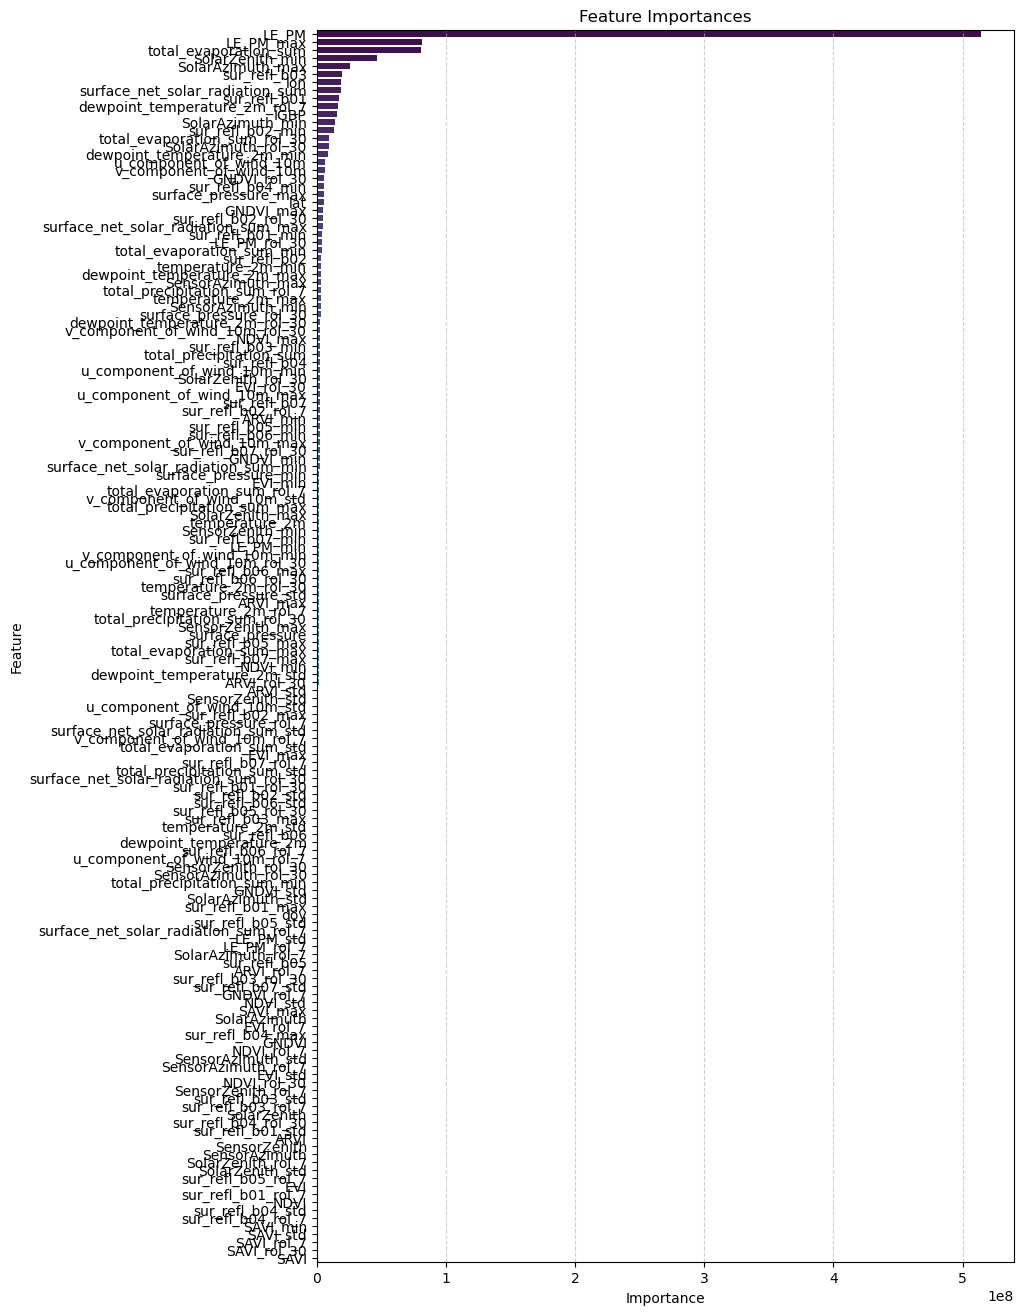

In [38]:
fi_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm.feature_importance(importance_type='gain')  # or 'split'
})

fi_df = fi_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(9, 16))
sns.barplot(x='importance', y='feature', data=fi_df, palette='viridis')

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()

In [39]:
fi_filt = (fi_df.importance - fi_df.importance.min())/(fi_df.importance.max()-fi_df.importance.min())
fi_filt[fi_filt>0.01].index

Index([ 19, 123,   5,  77,  83,  14, 152,   4,  12,  31, 153,  82,  92,  50,
        80,  32,   2,   3, 135, 102,  58, 151],
      dtype='int64')

In [40]:
fi_df.loc[fi_filt[fi_filt>0.01].index.tolist(), :].feature.tolist()

['LE_PM',
 'LE_PM_max',
 np.str_('total_evaporation_sum'),
 'SolarZenith_min',
 'SolarAzimuth_max',
 'sur_refl_b03',
 'lon',
 np.str_('surface_net_solar_radiation_sum'),
 'sur_refl_b01',
 'dewpoint_temperature_2m_rol_7',
 'IGBP',
 'SolarAzimuth_min',
 'sur_refl_b02_min',
 'total_evaporation_sum_rol_30',
 'SolarAzimuth_rol_30',
 'dewpoint_temperature_2m_min',
 np.str_('u_component_of_wind_10m'),
 np.str_('v_component_of_wind_10m'),
 'GNDVI_rol_30',
 'sur_refl_b04_min',
 'surface_pressure_max',
 'lat']

In [61]:
top_features = ['LE_PM',
 'SolarAzimuth_max',
 'sense_heat',
 'netrad',
 'lon',
 'SolarAzimuth_min',
 'vpd',
 'IGBP',
 'GNDVI_max',
 'SolarAzimuth_rol_30',
 'SolarZenith_min',
 'wind',
 'ground_flux']